In [32]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b = .03, r_0=.03, sigma=.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=.07, sigma = .15)


In [13]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=.7)

pd.concat([erk.terminal_stats(rets_zc, name = 'ZC', floor=.75),
          erk.terminal_stats(rets_eq, name = 'Eq', floor=.75),
          erk.terminal_stats(rets_7030b, name = '70/30', floor=.75),], axis = 1).round(2)
#we still sometimes have breaches. rn our allocator is blind to the floor

,ZC,Eq,70/30
mean,1.34,1.98,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.13,0.06
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [14]:
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP with the goal to provide exposure to upside
    without violating floor
    Uses CPPI style risk budgeting to invest a multiple of cushion in PSP
    Returns DF with same shape as psp/ghp representing weights in gsp
    """
    
    if zc_prices.shape != psp_r.shape:
        raise ValueError('Psp and ZC prices must have same shape')
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index = psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor * zc_prices.iloc[step] #PV of floor assuming today's rates and flat YC
        cushion = (account_value - floor_value) / account_value
        psp_w = (m*cushion).clip(0,1)
        ghp_w = 1-psp_w
        psp_alloc = account_value * psp_w
        ghp_alloc = account_value * ghp_w
        #Recompute account value at end of step
        account_value = psp_alloc * (1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

In [15]:
rets_floor75 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, 
                          floor=.75, zc_prices = zc_prices[1:])

pd.concat([erk.terminal_stats(rets_zc, name = 'ZC', floor=.75),
          erk.terminal_stats(rets_eq, name = 'Eq', floor=.75),
          erk.terminal_stats(rets_7030b, name = '70/30', floor=.75),
          erk.terminal_stats(rets_floor75, name = 'Floor75', floor=.75)], axis = 1).round(2)

,ZC,Eq,70/30,Floor75
mean,1.34,1.98,1.76,1.95
std,0.00,0.99,0.60,0.99
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.13,0.06,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [17]:
rets_floor75m1 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, 
                          floor=.75, zc_prices = zc_prices[1:], m = 1)
rets_floor75m5 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, 
                          floor=.75, zc_prices = zc_prices[1:], m = 5)
rets_floor75m10 = erk.bt_mix(rets_eq, rets_zc, allocator=erk.floor_allocator, 
                          floor=.75, zc_prices = zc_prices[1:], m = 10)

pd.concat([erk.terminal_stats(rets_zc, name = 'ZC', floor=.75),
          erk.terminal_stats(rets_eq, name = 'Eq', floor=.75),
          erk.terminal_stats(rets_7030b, name = '70/30', floor=.75),
          erk.terminal_stats(rets_floor75, name = 'Floor75', floor=.75),
          erk.terminal_stats(rets_floor75m1, name = 'Floor75m1', floor=.75),
          erk.terminal_stats(rets_floor75m5, name = 'Floor75m5', floor=.75),
           erk.terminal_stats(rets_floor75m10, name = 'Floor75m10', floor=.75)], axis = 1).round(3)
#STILL no violations

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10
mean,1.343,1.978,1.762,1.954,1.625,1.964,1.966
std,0.000,0.986,0.599,0.993,0.435,0.994,0.995
p_breach,NaN,0.034,0.010,NaN,NaN,NaN,0.022
e_short,NaN,0.131,0.065,NaN,NaN,NaN,0.005
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Budgeting with Drawdown Constraints

In [20]:
cashrate = .02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data = monthly_cashreturn, index = rets_eq.index, columns = rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)

In [25]:
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(rets_eq, rets_cash, allocator=erk.drawdown_allocator, maxdd=.25)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([erk.terminal_stats(rets_zc, name="ZC", floor=0.75), 
           erk.terminal_stats(rets_eq, name="Eq", floor=0.75),
           erk.terminal_stats(rets_7030b, name="70/30", floor=0.75),
           erk.terminal_stats(rets_floor75, name="Floor75", floor=0.75),
           erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=0.75),
           erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=0.75),
           erk.terminal_stats(rets_floor75m10, name="Floor75m10", floor=0.75),
           erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75)           
          ],
          axis=1).round(2)

,ZC,Eq,70/30,Floor75,Floor75m1,Floor75m5,Floor75m10,MaxDD25
mean,1.34,1.98,1.76,1.95,1.63,1.96,1.97,1.63
std,0.00,0.99,0.60,0.99,0.44,0.99,0.99,0.54
p_breach,NaN,0.03,0.01,NaN,NaN,NaN,0.02,NaN
e_short,NaN,0.13,0.06,NaN,NaN,NaN,0.00,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].head()

0   -0.205195
1   -0.184057
2   -0.190507
3   -0.167236
4   -0.179914
Name: Max Drawdown, dtype: float64

In [23]:
erk.summary_stats(rets_maxdd25)['Max Drawdown'].min()

-0.23272348497573914

/opt/anaconda3/envs/IMSpecialization/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/IMSpecialization/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/envs/IMSpecialization/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

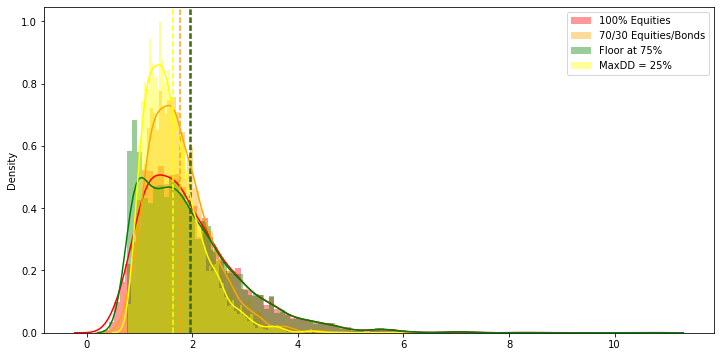

In [26]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)
import seaborn as sns
import matplotlib.pyplot as plt
# Plot
plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
#sns.distplot(tv_zc, color="blue", label="100% Immunized Bonds")
#plt.axvline(tv_zc.mean(), ls="--", color="blue")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")
plt.legend();

In [27]:
# Drawdown with Historical Data

<AxesSubplot:>

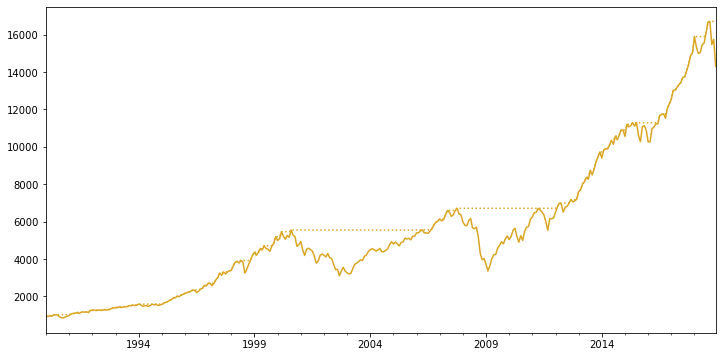

In [35]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

<AxesSubplot:>

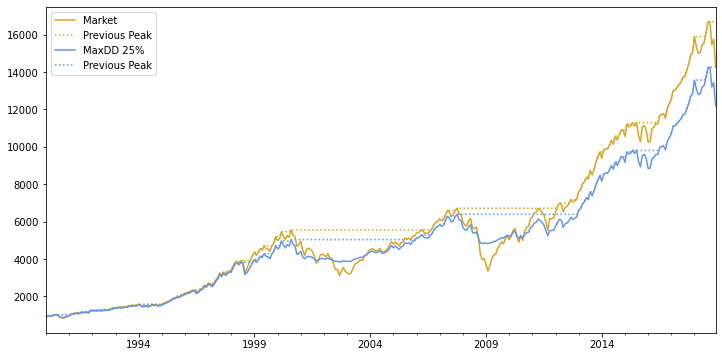

In [37]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)

dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod", legend = True)
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":", legend = True)